In [1]:
# データセット読み込みと整形
import load_sms_call_internet_mi

time_unit = 'minute'
CellID = 1

train, test, y_datetime = load_sms_call_internet_mi.load_dataset_ID(time_unit, CellID)

In [2]:
# xに説明変数を、yに目的変数を格納
train_x = train.drop(columns=['internet'])
train_y = train['internet']
test_x = test.drop(columns=['internet'])
test_y = test['internet']

In [3]:
# 値を0～1の範囲に正規化し、pandas DataframeからNumPy配列に変更（mms_yは評価指標に使用）
import normalize_train_test
train_x, test_x, train_y, test_y, mms_y = normalize_train_test.apply_MMS(train_x, test_x, train_y, test_y)

In [4]:
# ["データ数", "timesteps", "特徴量数"]の三次元構造に変換（x_train, x_testに名称変更）
# timesteps時間以降のデータを目的変数に設定（y_train, y_testに名称変更）
import set_timesteps
timesteps = 24*6
x_train, x_test, y_train, y_test = set_timesteps.create_timeseries_data(train_x, test_x, train_y, test_y, timesteps)

In [7]:
# モデル構築
import build_model
model, history = build_model.build_model_GRU_Optuna(x_train, y_train, timesteps, time_unit)

[I 2025-01-08 16:05:49,295] A new study created in memory with name: no-name-376baebf-bdaf-46a9-9059-feea99656133


Enabled dynamic memory allocation.


[I 2025-01-08 16:07:19,756] Trial 0 finished with value: 0.004142028279602528 and parameters: {'neuron': 64, 'batch_size': 64, 'learning_rate': 0.0002215953929680393}. Best is trial 0 with value: 0.004142028279602528.
[I 2025-01-08 16:10:45,735] Trial 1 finished with value: 0.0025335471145808697 and parameters: {'neuron': 256, 'batch_size': 32, 'learning_rate': 0.00046823892083856507}. Best is trial 1 with value: 0.0025335471145808697.
[I 2025-01-08 16:12:05,612] Trial 2 finished with value: 0.0025294655933976173 and parameters: {'neuron': 64, 'batch_size': 32, 'learning_rate': 0.0004924051830595188}. Best is trial 2 with value: 0.0025294655933976173.
[I 2025-01-08 16:13:18,764] Trial 3 finished with value: 0.0036391555331647396 and parameters: {'neuron': 64, 'batch_size': 32, 'learning_rate': 0.0002636984791176975}. Best is trial 2 with value: 0.0025294655933976173.
[I 2025-01-08 16:14:57,674] Trial 4 finished with value: 0.0025836999993771315 and parameters: {'neuron': 32, 'batch_siz

Best hyperparameters: {'neuron': 128, 'batch_size': 64, 'learning_rate': 0.0007914440767010942}
Best model saved as 'C:\Users\goshima\Documents\卒業研究_AI\Python\Datasets\best_model\minute\best_model.h5'


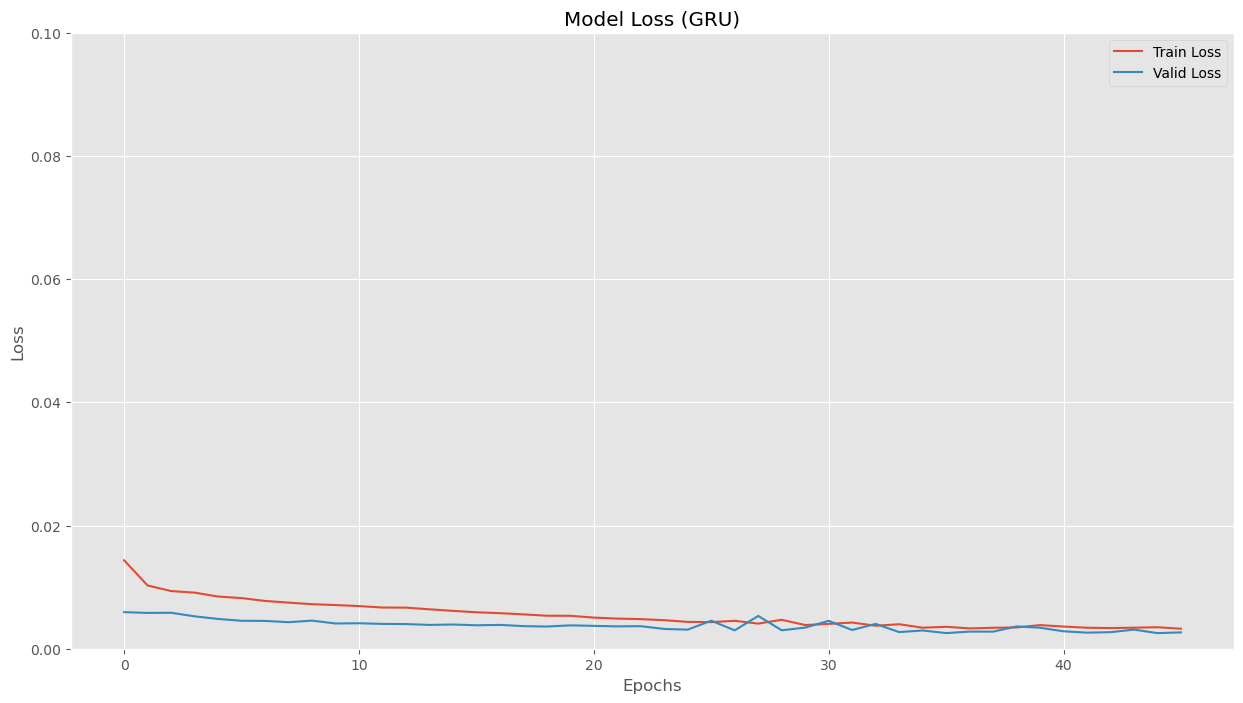

In [10]:
import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフスタイル

plt.figure(figsize=(15, 8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Valid Loss')
plt.title('Model Loss (GRU)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')

# y軸の上限値を指定（例：0から1.0までの範囲に設定）
plt.ylim(0, 0.1)
plt.show()

In [11]:
# テストデータに対する予測を行い、評価結果を表示
import evaluate_model_performance
y_test_pred, y_test_true = evaluate_model_performance.evaluate_model(x_test, y_test, mms_y, model)

32/32 [==============================] - 1s 10ms/step
RMSE: 1.5675727675522948
MAE: 1.2147135850603057
MAPE: 0.11842878486550469
MdAPE: 10.171592844268535
GMAPE: 11.511802181808406
R2: 0.733434004620861
MASE: 1.1767485547456098
SMAE: 0.11607157024370378


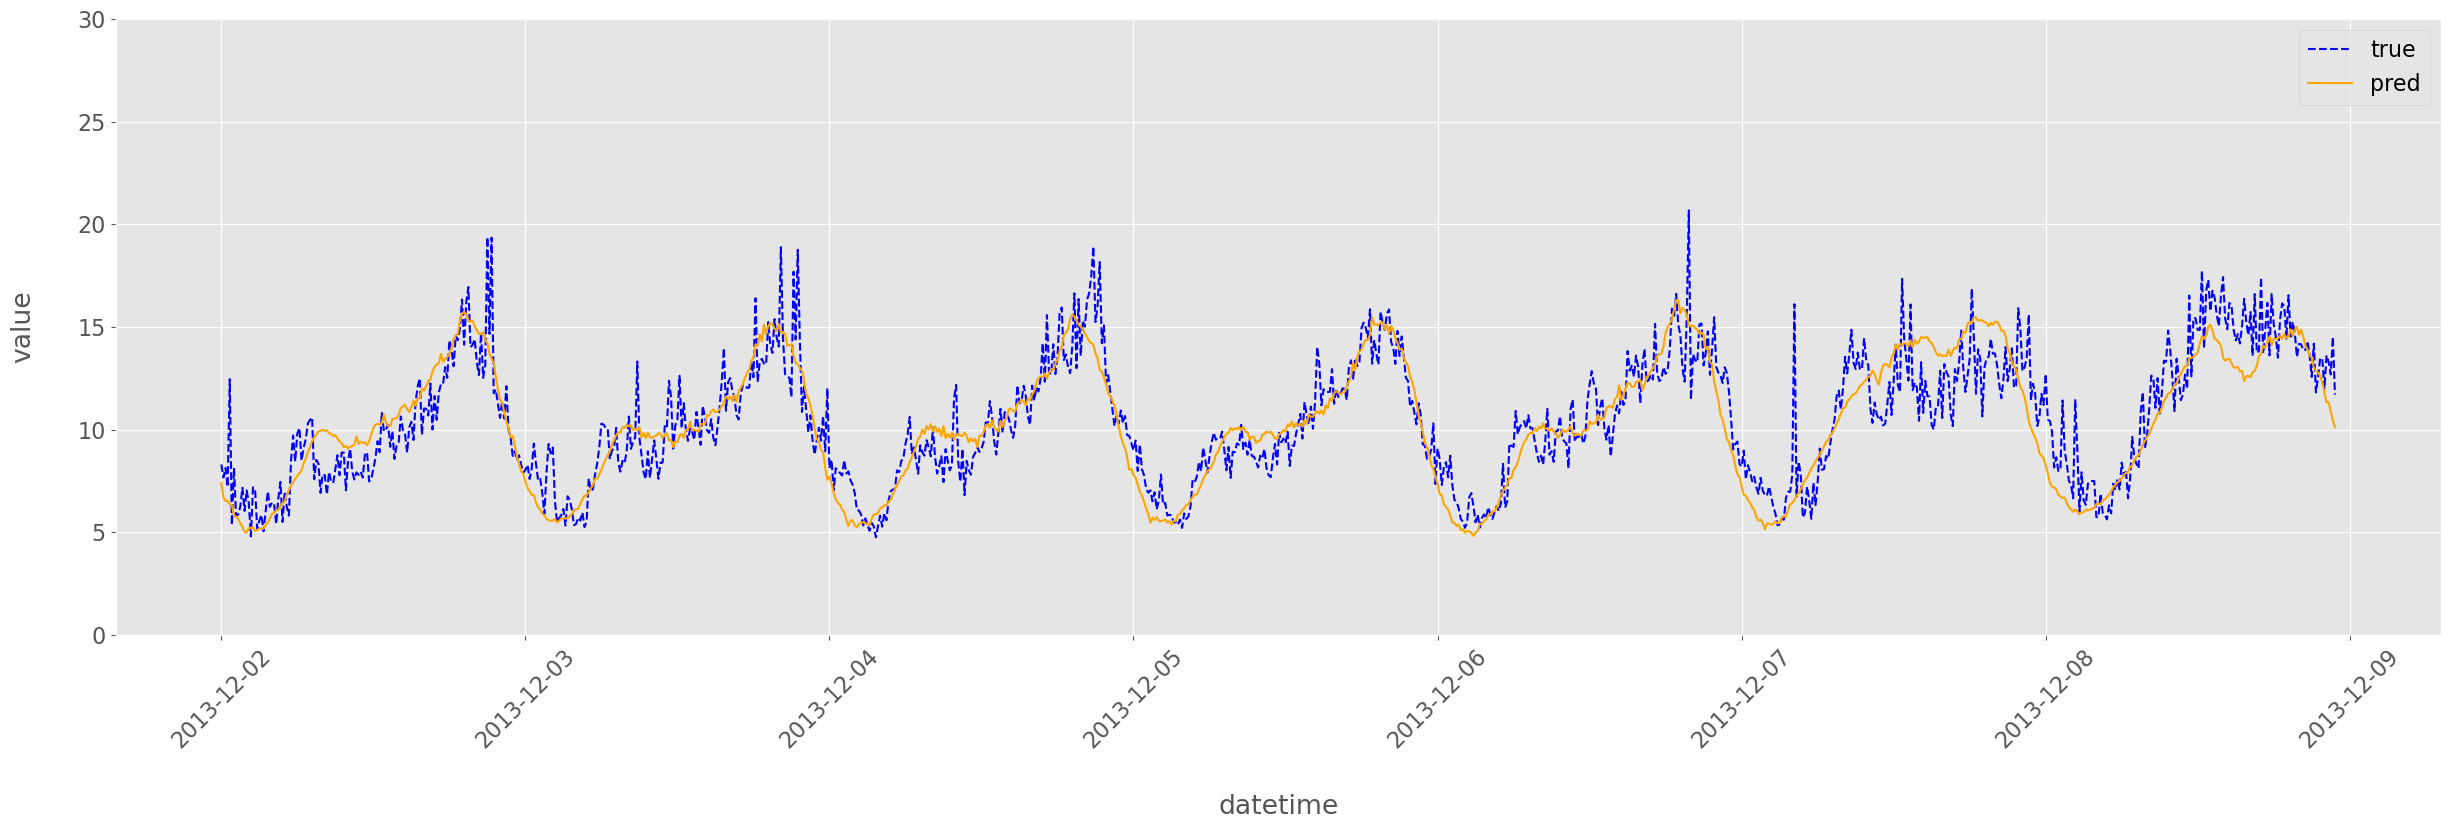

In [12]:
from matplotlib.dates import AutoDateLocator, DateFormatter
import pandas as pd
import matplotlib.pyplot as plt

# datetimeの型を確認・変換
datetime = y_datetime[timesteps:].reset_index(drop=True)
datetime = pd.to_datetime(datetime)

# 全体のフォントサイズを設定
plt.rcParams.update({'font.size': 16})

# グラフの描画
plt.figure(figsize=(30, 8))
plt.plot(datetime, y_test_true, linestyle='--', color='blue', label='true')
plt.plot(datetime, y_test_pred, color='orange', label='pred')

# x軸の目盛りを調整
ax = plt.gca() 
locator = AutoDateLocator() 
formatter = DateFormatter("%Y-%m-%d") 
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

# ラベルを回転して見やすくする
plt.xticks(rotation=45)

# その他設定
plt.ylabel('value', labelpad=30)
plt.xlabel('datetime', labelpad=30)
plt.legend(loc='upper right')

plt.ylim(0, 30)
plt.show()